In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Parsers as P, Utilities as U
from mppi.Calculators import Tools
from mppi.Datasets import PostProcessing as PP
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
# sync the GW folder from m100 to the ismhpc
dry_run = True
rsync_str = "rsync -rDzv --exclude={'*_fragment*','*_fragments_*','*wfc*','*.dat','.ipynb_checkpoints'} "
if dry_run: rsync_str += '-n '
ssh_str = '-e ssh m100:/m100/home/userexternal/mdaless1/work/Xenes/Stanene/GW_analysis '
dest_path = 'GW_analysis'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)

rsync -rDzv --exclude={'*_fragments*','*_fragments_*','*wfc*','*.dat','.ipynb_checkpoints'} -n -e ssh m100:/m100/home/userexternal/mdaless1/work/Xenes/Stanene/GW_analysis '/m100_work/IscrC_PrExIn/Stanene/GW_analysis'


In [ ]:
# RunRules for local computations
mpi = 4
omp = 2

rr = C.RunRules(omp_num_threads=omp,mpi=mpi)
code = C.QeCalculator(rr)
#code.global_options()

In [ ]:
# RunRules for ismhpc
# The product of ntasks_per_node*cpus_per_task is equal to 32. 
# Many mpi are needed for better performances
nodes = 2
ntasks_per_node = 32 #16
cpus_per_task = 1 #2
omp_num_threads = 1 #2

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='all12h',
                memory='125000',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,
                omp_num_threads=omp_num_threads)
code = C.YamboCalculator(rr,activate_BeeOND=True) #,reformat=False,clean_restart=False,skip=False,fatlog=True)
code.global_options()

In [8]:
# RunRules for m100
nodes = 16 # 16
ntasks_per_node = 4
cpus_per_task=32
omp_num_threads=8
gpus_per_node=4
pe=8

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='m100_usr_prod',
                account='IscrC_PrExIn',
                memory='240GB',time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gpus_per_node=gpus_per_node,pe=pe,
                map_by='socket',rank_by='core')
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 16,
 'ntasks_per_node': 4,
 'cpus_per_task': 32,
 'omp_num_threads': 8,
 'gpus_per_node': 4,
 'memory': '240GB',
 'time': '23:59:00',
 'partition': 'm100_usr_prod',
 'account': 'IscrC_PrExIn',
 'qos': None,
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

# GW convergence analysis for Plumbene monolayer

We perform a convergence study for the GW runlevel.

As control quantities we choose the direct gap at K and the indirect gap. However, for this quantity
we consider the gap from $\Gamma$ to $K$, since the $\Gamma$ point is included in all the samplings, while
the true position of the valence band maximum is not the same in the various k-sampling.

## HF Analysis

We do not repeat the convergence tests on the rim and Coulomb cutoff and we directly set
the values of the converged parameters found in the analysis of the other Xenes

* RandGVec = 200
* RandQPpts = 5000000

### HF convergence analysis for the cutoff in the exchange term

We study the convergence of the HF calculations in terms of the cutoff in the exchange term.

This analysis is performed with a 18x18x1 k-points sampling using the converged results for RIM and Coulomb cutoff.

__Note that we apply the cutoff on the EXXRLvcs variable while the VXCRLvcs is left to its DFT value__

In [4]:
input_dir = 'DFT_analysis/kpoints_18-nbnds_30.save'
run_dir = 'MB_analysis/kpoints_18-nbnds_30'

Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_18-nbnds_30/SAVE already present. No operations performed.


We the define the input variables commmon to all the runs

In [5]:
val_band,cond_band = 28,29 # bands range for the computation of the HF corrections
G_index, K_index = 1, 37
RandGvec = 200
Randqpts = 5e6

EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_bandRange(val_band,cond_band)
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec)
inp

{'args': 'yambo -r -x -V all',
 'folder': 'MB_analysis/kpoints_18-nbnds_30',
 'filename': 'yambo.in',
 'arguments': ['rim_cut', 'HF_and_locXC'],
 'variables': {'StdoHash': [40.0, ''],
  'Nelectro': [28.0, ''],
  'ElecTemp': [0.0, 'eV'],
  'BoseTemp': [-1.0, 'eV'],
  'OccTresh': [1e-05, ''],
  'NLogCPUs': [0.0, ''],
  'MEM_tresh': [51200.0, 'Kb'],
  'FFTGvecs': [17669.0, 'RL'],
  'SE_Threads': [0.0, ''],
  'RandQpts': [5000000.0, ''],
  'RandGvec': [200, 'RL'],
  'IDEm1Ref': [0.0, ''],
  'CUTRadius': [0.0, ''],
  'CUTCylLen': [0.0, ''],
  'CUTwsGvec': [0.7, ''],
  'EXXRLvcs': [107171.0, 'RL'],
  'VXCRLvcs': [107171.0, 'RL'],
  'DBsIOoff': 'none',
  'DBsFRAGpm': 'none',
  'PAR_def_mode': 'balanced',
  'CUTGeo': 'slab z',
  'Em1Anys': [[0.0, 0.0, 0.0], ''],
  'CUTBox': [[0.0, 0.0, 0.0], ''],
  'QPkrange': [[1, 37, 28, 29], ''],
  'QPerange': [[1, 37, 0.0, '-1.000000'], '']}}

We perform a convergence run on the EXXRLvcs parameter

In [8]:
study = D.Dataset(run_dir=run_dir,num_tasks=4,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

EXXRLvcs = [10.,20.,30.,40.,50.] # Ha

for exxrlvcs in EXXRLvcs:
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    
    idd = 'hf-G-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(G_index,G_index)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

    idd = 'hf-K-exxrlvcs_%s'%exxrlvcs
    inp.set_kRange(K_index,K_index)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=exxrlvcs)
    study.append_run(id=idd,input=inp,runner=code,jobname =idd)

Initialize a Dataset with 4 parallel tasks


In [9]:
#study.runs[0]

In [13]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9]] 

Run the task [0, 1, 2, 3] 
Skip the run of hf-G-exxrlvcs_10.0
Skip the run of Skip the run ofhf-K-exxrlvcs_10.0 
hf-G-exxrlvcs_20.0
Skip the run of hf-K-exxrlvcs_20.0
Task [0, 1, 2, 3] ended 
 
Run the task [4, 5, 6, 7] 
Skip the run of Skip the run ofhf-G-exxrlvcs_30.0 
Skip the run ofhf-K-exxrlvcs_30.0 
hf-G-exxrlvcs_40.0
Skip the run of hf-K-exxrlvcs_40.0
Task [4, 5, 6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-G-exxrlvcs_50.0
Skip the run of hf-K-exxrlvcs_50.0
Task [8, 9] ended 
 


We plot the values of the gap

In [11]:
gap, gap_K = [],[]
for ind in range(len(EXXRLvcs)):
    gap.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind].data.get_energy(G_index,val_band))
    gap_K.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind+1].data.get_energy(K_index,val_band))
gap,gap_K

([2.644245, 2.6490299999999998, 2.649197, 2.649199, 2.649199],
 [3.222966, 3.224072, 3.22405, 3.22405, 3.22405])

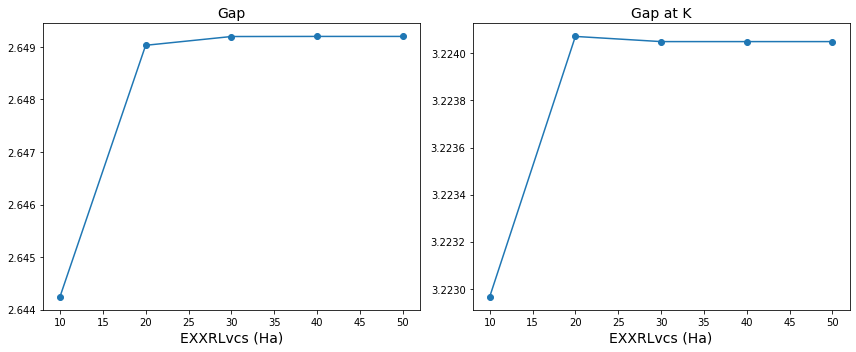

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(EXXRLvcs,gap)
axes[0].scatter(EXXRLvcs,gap)
axes[0].set_title('Gap',size=14)
axes[0].set_xlabel('EXXRLvcs (Ha)',size=14)
axes[1].plot(EXXRLvcs, gap_K)
axes[1].scatter(EXXRLvcs,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('EXXRLvcs (Ha)',size=14)
fig.tight_layout()

On the basis of this analysis we choose the converged value of the cutoff for exchange as

EXXRLvcs = 30 Ha

### HF Analysis in function of the k-points sampling

We test the convergence of the HF gap at $K$ and at the $\Gamma$ points in funciont of the dimension of the $k$-points sampling.

The converged parameters for the RIM and Coulomb cutoff and for the cutoff on the exchange derived in the previous analysis will be used.

In [14]:
RandQpts = 5000000
RandGvec = 200 

val_band,cond_band = 28,29 # bands range for the computation of the HF corrections
G_index = {18:1,30:1,42:1,60:1,72:1}
K_index = {18:37,30:91,42:169,60:331,72:469}

EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'

In [15]:
kpoints = [18,30,42,60,72]

In [17]:
study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in kpoints:
    input_dir = 'DFT_analysis/kpoints_%s-nbnds_30.save'%k
    run_dir = 'MB_analysis/kpoints_%s-nbnds_30'%k
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)
    
    inp = I.YamboInput(args='yambo -r -x -V all',folder=run_dir)
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs)
    inp.set_bandRange(val_band,cond_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=RandQpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec)
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.1.16') # for 1 nodes on ismhpc (with 32 mpi and 1 omp per node)
    
    # append run at G
    idd = 'hf-G-kpoints_%s'%k
    inp.set_kRange(G_index[k],G_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])
    # append run at K
    idd = 'hf-K-kpoints_%s'%k
    inp.set_kRange(K_index[k],K_index[k])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff'])

Initialize a Dataset with 2 parallel tasks
SAVE folder MB_analysis/kpoints_18-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_30-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_42-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_60-nbnds_30/SAVE already present. No operations performed.
SAVE folder MB_analysis/kpoints_72-nbnds_30/SAVE already present. No operations performed.


In [28]:
#study.runs[0]

In [19]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of hf-G-kpoints_18
Skip the run of hf-K-kpoints_18
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of hf-G-kpoints_30Skip the run of
 hf-K-kpoints_30
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of hf-G-kpoints_42Skip the run of
 hf-K-kpoints_42
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of hf-G-kpoints_60Skip the run of
 hf-K-kpoints_60
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of hf-G-kpoints_72Skip the run of
 hf-K-kpoints_72
Task [8, 9] ended 
 


In [22]:
gap, gap_K = [],[]
for ind,k in enumerate(kpoints):
    gap.append(results[2*ind+1].data.get_energy(K_index[k],cond_band)-results[2*ind].data.get_energy(G_index[k],val_band))
    gap_K.append(results[2*ind+1].data.get_energy(K_index[k],cond_band)-results[2*ind+1].data.get_energy(K_index[k],val_band))
gap,gap_K

([2.649197, 2.656427, 2.659701, 2.661599, 2.6626260000000004],
 [3.22405, 3.227898, 3.231033, 3.233004, 3.233922])

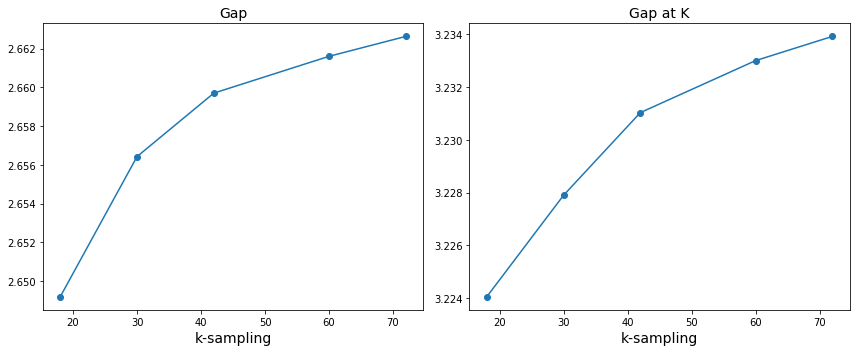

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap)
axes[0].scatter(kpoints,gap)
axes[0].set_title('Gap',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_title('Gap at K',size=14)
axes[1].set_xlabel('k-sampling',size=14)
fig.tight_layout()

With the 60x60x1 sampling the HF indirec gap asnd the direct gap at $K$ is converged at
the level of 2-3 meV. Instead considering the 42x42x1 sampling the convergence is at the order
of 5-7 meV.

## Plasmon pole analysis

We study the convergence of the gap at $\Gamma$ and at $K$ using the plasmon pole run level. 

The aim of this analysis is to find a converged expression for the screening (that will be used also in the BSE calculations)
and to test the RIM_W.

### Convergence analysis of the screening

We use the 18x18x1 k-points sampling and perform a convergence analysis in the BndsRnXp and GbndRnge parameters
needed to compute the screening function.

We perform this analysis using the RIM_W with RandGvecW=10.

In [58]:
input_dir = 'DFT_analysis/kpoints_18-nbnds_700.save'
run_dir = 'MB_analysis/kpoints_18-nbnds_700'
Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir)

SAVE folder MB_analysis/kpoints_18-nbnds_700/SAVE already present. No operations performed.


We the define the input variables common to all the runs

In [59]:
ntasks_c = 32 #16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

val_band,cond_band = 28,29
G_index, K_index = 1, 37
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLvcs = 30. # Ha
EXXRLVcs_units = 'Ha'

inp = I.YamboInput(args='yambo -r -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.activate_RIM_W()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs) 
inp.set_bandRange(val_band,cond_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='2.2.16') # for 2 nodes on ismhpc (with 32 mpi and 1 omp per node)
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
#inp

32 2


First we run over NGsBlkXp

In [60]:
NGsBlkXp = [4.0,6.0,8.0] # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp  = [1,300] # Bands in the response function
GbndRnge = [1,300]  # Bands in the Sigma_c

inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for ngsblkxp in NGsBlkXp:
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=ngsblkxp)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(Gamma_index,Gamma_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(ngsblkxp,BndsRnXp[1],GbndRnge[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(ngsblkxp,BndsRnXp[1])],reformat=False)

Initialize a Dataset with 2 parallel tasks


In [61]:
study.ids

['pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300',
 'pp-K-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300',
 'pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300',
 'pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300',
 'pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300',
 'pp-K-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300']

In [62]:
#study.runs[0]

In [63]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5] with the parallel task_groups [[0, 1], [2, 3], [4, 5]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-K-ngsblkxp_4.0-bndsrnxp_300-gbndrnge_300
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-K-ngsblkxp_8.0-bndsrnxp_300-gbndrnge_300
Task [4, 5] ended 
 


In [64]:
gap, gap_K = [],[]
for ind in range(len(NGsBlkXp)):
    gap.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind].data.get_energy(G_index,val_band))
    gap_K.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind+1].data.get_energy(K_index,val_band))
gap,gap_K

([0.7723420000000001, 0.772484, 0.772401],
 [0.8685170000000001, 0.8674200000000001, 0.866781])

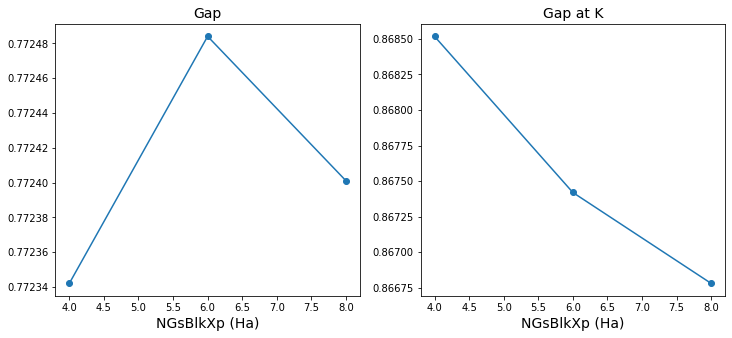

In [65]:
ig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(NGsBlkXp,gap)
axes[0].scatter(NGsBlkXp,gap)
axes[0].set_title('Gap',size=14)
axes[0].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].plot(NGsBlkXp, gap_K)
axes[1].scatter(NGsBlkXp,gap_K)
axes[1].set_xlabel('NGsBlkXp (Ha)',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

We choose the value NGsBlkXp = 6 Ha that ensures convergence at the level of abount 1 meV for
both the $\Gamma$ and the K points.

Next, we perform a convergence analysis on the number of bands. Here we choose to analyze the combined 
effect of the BndsRnXp and of the GbndRnge parameters. So we iterate over both the parameters.

In [67]:
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500],[1,600],[1,700]] # Bands in the response function and in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands,GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(G_index,G_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 

Initialize a Dataset with 2 parallel tasks


In [68]:
study.ids

['pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300',
 'pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300',
 'pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400',
 'pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500',
 'pp-K-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500',
 'pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600',
 'pp-K-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600',
 'pp-G-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700',
 'pp-K-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700']

In [69]:
#study.runs[2]

In [70]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700
Task [8, 9] ended 
 


In [71]:
gap, gap_K = [],[]
for ind in range(len(Bands)):
    gap.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind].data.get_energy(G_index,val_band))
    gap_K.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind+1].data.get_energy(K_index,val_band))
gap,gap_K

([0.772484, 0.77881, 0.782369, 0.784478, 0.784923],
 [0.8674200000000001, 0.869541, 0.8715269999999999, 0.873232, 0.875094])

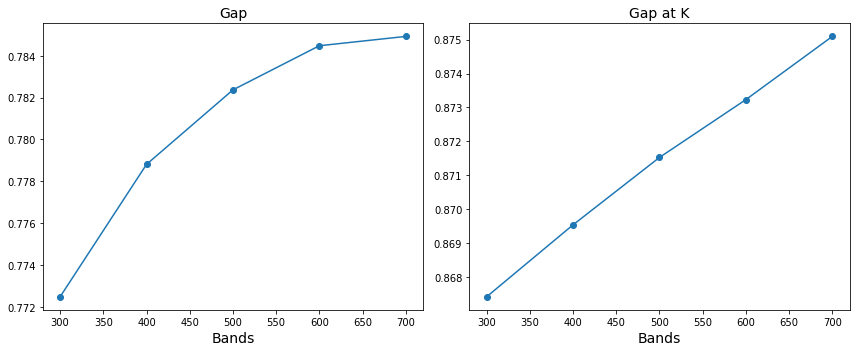

In [72]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap)
axes[0].scatter(x_vals,gap)
axes[0].set_title('Gap',size=14)
axes[0].set_xlabel('Bands',size=14)
axes[1].plot(x_vals, gap_K)
axes[1].scatter(x_vals,gap_K)
axes[1].set_xlabel('Bands',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

On the basis of this analysis we conclude that NGsBlkXp = 6 Ha, BndsRnXp = GbndRnge = 700 guarantees convergence
at the level few meV for the indirect gap. Instead the convergence for the direct gap at K seems to be
more demanding in terms of the number of bands.

We also test the effect of the terminator both on the GbndRnge and on the number of bands in the screening.

#### Test of the terminator on GbndRnge

In [73]:
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands  = [[1,300],[1,400],[1,500],[1,600],[1,700]] # Bands in the response function and in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_scalar_variables(GTermKind='BG')

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands:
    inp.set_array_variables(BndsRnXp=bands,GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-term_Gbnd'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(G_index,G_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-term_Gbnd'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,bands[1])],reformat=False) 

Initialize a Dataset with 2 parallel tasks


In [74]:
study.ids

['pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300-term_Gbnd',
 'pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300-term_Gbnd',
 'pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_Gbnd',
 'pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_Gbnd',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_Gbnd',
 'pp-K-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_Gbnd',
 'pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_Gbnd',
 'pp-K-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_Gbnd',
 'pp-G-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_Gbnd',
 'pp-K-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_Gbnd']

In [75]:
#study.runs[0]

In [76]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300-term_Gbnd
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_300-gbndrnge_300-term_Gbnd
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_Gbnd
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_Gbnd
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_Gbnd
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_Gbnd
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_Gbnd
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_Gbnd
Task [6, 7] ended 
 
Run the task [8, 9] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_Gbnd
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700

In [77]:
gap_term, gap_K_term = [],[]
for ind in range(len(Bands)):
    gap_term.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind].data.get_energy(G_index,val_band))
    gap_K_term.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind+1].data.get_energy(K_index,val_band))
gap_term,gap_K_term

([0.7858780000000001, 0.7898820000000001, 0.791321, 0.791761, 0.791208],
 [0.8810410000000001, 0.881822, 0.882258, 0.882831, 0.8836])

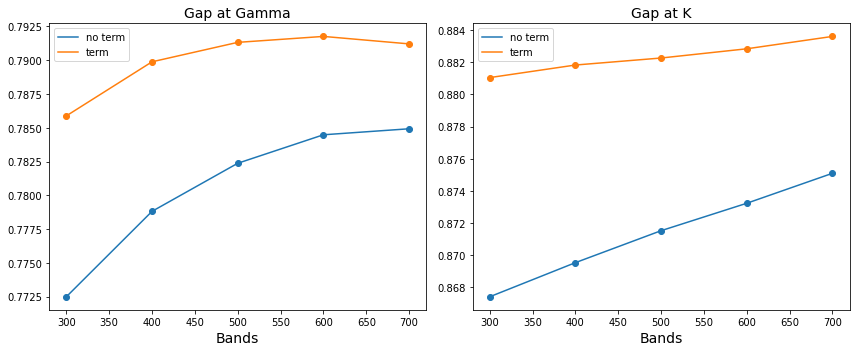

In [78]:
x_vals = [x[1] for x in Bands]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap,label='no term')
axes[0].scatter(x_vals,gap)
axes[0].plot(x_vals,gap_term,label='term')
axes[0].scatter(x_vals,gap_term)
axes[0].set_title('Gap',size=14)
axes[0].set_xlabel('Bands',size=14)
axes[0].legend()
axes[1].plot(x_vals,gap_K,label='no term')
axes[1].scatter(x_vals,gap_K)
axes[1].plot(x_vals, gap_K_term,label='term')
axes[1].scatter(x_vals,gap_K_term)
axes[1].set_xlabel('Bands',size=14)
axes[1].set_title('Gap at K',size=14)
axes[1].legend()
fig.tight_layout()

#### Test of the terminator on BndsRnXp and GbndRnge

In [79]:
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
Bands_term_all  = [[1,400],[1,500],[1,600],[1,700]] # Bands in the response function and in the Sigma_c

inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_scalar_variables(GTermKind='BG')
inp.set_scalar_variables(XTermKind='BG')

study = D.Dataset(num_tasks=2,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for bands in Bands_term_all:
    inp.set_array_variables(BndsRnXp=bands,GbndRnge=bands)
    # append run at G
    idd = 'pp-G-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-term_all'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(G_index,G_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_G',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s-term'%(NGsBlkXp,bands[1])],reformat=False) 
    # append run at K
    idd = 'pp-K-ngsblkxp_%s-bndsrnxp_%s-gbndrnge_%s-term_all'%(NGsBlkXp,bands[1],bands[1])
    inp.set_kRange(K_index,K_index)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndb_rim_cutoff','ndb_hf_K',
                     'ndb_em1d-ngsblkxp_%s-bndsrnxp_%s-term'%(NGsBlkXp,bands[1])],reformat=False) 

Initialize a Dataset with 2 parallel tasks


In [80]:
study.ids

['pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_all',
 'pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_all',
 'pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_all',
 'pp-K-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_all',
 'pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_all',
 'pp-K-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_all',
 'pp-G-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_all',
 'pp-K-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_all']

In [81]:
results = study.run()

Run the selection [0, 1, 2, 3, 4, 5, 6, 7] with the parallel task_groups [[0, 1], [2, 3], [4, 5], [6, 7]] 

Run the task [0, 1] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_all
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_400-gbndrnge_400-term_all
Task [0, 1] ended 
 
Run the task [2, 3] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_all
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_500-gbndrnge_500-term_all
Task [2, 3] ended 
 
Run the task [4, 5] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_all
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_600-gbndrnge_600-term_all
Task [4, 5] ended 
 
Run the task [6, 7] 
Skip the run of pp-G-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_all
Skip the run of pp-K-ngsblkxp_6.0-bndsrnxp_700-gbndrnge_700-term_all
Task [6, 7] ended 
 


In [82]:
gap_term_all, gap_K_term_all = [],[]
for ind in range(len(Bands_term_all)):
    gap_term_all.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind].data.get_energy(G_index,val_band))
    gap_K_term_all.append(results[2*ind+1].data.get_energy(K_index,cond_band)-results[2*ind+1].data.get_energy(K_index,val_band))
gap_term_all,gap_K_term_all

([0.8272069999999999, 0.820377, 0.8161949999999999, 0.8143070000000001],
 [0.9581620000000001, 0.9485899999999999, 0.942603, 0.9397])

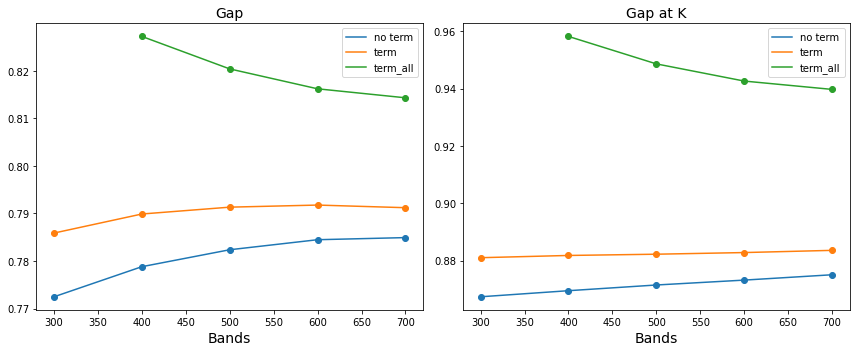

In [84]:
x_vals = [x[1] for x in Bands]
x_vals_term_all = [x[1] for x in Bands_term_all]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(x_vals,gap,label='no term')
axes[0].scatter(x_vals,gap)
axes[0].plot(x_vals,gap_term,label='term')
axes[0].scatter(x_vals,gap_term)
axes[0].plot(x_vals_term_all,gap_term_all,label='term_all')
axes[0].scatter(x_vals_term_all,gap_term_all)
axes[0].set_title('Gap',size=14)
axes[0].set_xlabel('Bands',size=14)
axes[0].legend()
axes[1].plot(x_vals,gap_K,label='no term')
axes[1].scatter(x_vals,gap_K)
axes[1].plot(x_vals, gap_K_term,label='term')
axes[1].scatter(x_vals,gap_K_term)
axes[1].plot(x_vals_term_all, gap_K_term_all,label='term_all')
axes[1].scatter(x_vals_term_all,gap_K_term_all)
axes[1].set_xlabel('Bands',size=14)
axes[1].set_title('Gap at K',size=14)
axes[1].legend()
fig.tight_layout()

The usage of the terminator (both the two) does not provide a clear improvement of the convergence of the gap. 

The term_all seems to converge to a different asymptotic value w.r.t the other curves so we do not trust its
reliability. The usage of the terminator on GbndRnge only could provide a little improvement and we can choose
500 bands with the GbndRnge terminator as the best choice for the subsequent analysis.

### PP Analysis in function of the k-points sampling

In [3]:
# RunRules for leonardo
nodes = 8
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 8,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We test the convergence of the PP gap at $K$ and at the $\Gamma$ points in function of the dimension of the $k$-points sampling.

We perform this analysis using the parameters NGsBlkXp = 6 Ha, BndsRnXp = GbndRnge = 500  mutuated from the previous analysis. 

In [4]:
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_500','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_500','K_index':331,'G_index':1},
            }

In [5]:
for k in ksamplings:
    input_dir=os.path.join('DFT_analysis',ksamplings[k]['folder']+'.save')
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    Tools.init_yambo_dir(yambo_dir=run_dir,input_dir=input_dir,p2y_command='OMP_NUM_THREADS=1 mpirun -np 1 p2y',yambo_command='OMP_NUM_THREADS=1 mpirun -np 1 yambo')

Create the folder path MB_analysis/kpoints_18-nbnds_500
Executing command: cd MB_analysis/kpoints_18-nbnds_500; OMP_NUM_THREADS=1 mpirun -np 1 p2y -I ../../DFT_analysis/kpoints_18-nbnds_500.save
MPI startup(): Warning: I_MPI_PMI_LIBRARY will be ignored since the hydra process manager was found
Build the r_setup in the yambo_dir path MB_analysis/kpoints_18-nbnds_500
Create the folder path MB_analysis/kpoints_60-nbnds_500
Executing command: cd MB_analysis/kpoints_60-nbnds_500; OMP_NUM_THREADS=1 mpirun -np 1 p2y -I ../../DFT_analysis/kpoints_60-nbnds_500.save
Build the r_setup in the yambo_dir path MB_analysis/kpoints_60-nbnds_500


In [12]:
ntasks_c = 16
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 28,29
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,500]
GbndRnge  = [1,500] # Bands in the G function
LongDrXp=[1.,1.,0.] 

study = D.Dataset(num_tasks=8,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

for k in ksamplings:
    run_dir=os.path.join('MB_analysis',ksamplings[k]['folder'])
    inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
    inp.set_extendOut()
    inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
    inp.set_array_variables(LongDrXp=LongDrXp)
    inp.set_bandRange(start_band,stop_band)
    inp.set_scalar_variables(CUTGeo='slab z')
    inp.set_array_variables(RandQpts=Randqpts)
    inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
    #inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
    inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.2.16') # for 8 nodes on leonardo
    inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
    inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
    inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
    inp.set_scalar_variables(GTermKind='BG')
    # append run at G
    idd = 'pp-G-kpoints_%s'%k
    inp.set_kRange(ksamplings[k]['G_index'],ksamplings[k]['G_index'])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)
    # append run at K
    idd = 'pp-K-kpoints_%s'%k
    inp.set_kRange(ksamplings[k]['K_index'],ksamplings[k]['K_index'])
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_%s-bndsrnxp_%s'%(NGsBlkXp,BndsRnXp[1])],reformat=False)


16 2
Initialize a Dataset with 8 parallel tasks


In [13]:
study.ids

['pp-G-kpoints_18x18x1',
 'pp-K-kpoints_18x18x1',
 'pp-G-kpoints_60x60x1',
 'pp-K-kpoints_60x60x1']

In [14]:
#study.runs[2]

{'label': 'Dataset',
 'run_dir': 'MB_analysis/kpoints_60-nbnds_500',
 'num_tasks': 8,
 'verbose': True,
 'input': {'args': 'yambo -r -rw -k hartee -dyson n -gw0 p -V all',
  'folder': 'MB_analysis/kpoints_60-nbnds_500',
  'filename': 'yambo.in',
  'arguments': ['rim_cut',
   'rim_w',
   'em1d',
   'gw0',
   'HF_and_locXC',
   'ppa',
   'ExtendOut'],
  'variables': {'StdoHash': [40.0, ''],
   'Nelectro': [28.0, ''],
   'ElecTemp': [0.0, 'eV'],
   'BoseTemp': [-1.0, 'eV'],
   'OccTresh': [1e-05, ''],
   'NLogCPUs': [0.0, ''],
   'MEM_tresh': [1210029.0, 'Kb'],
   'FFTGvecs': [17669.0, 'RL'],
   'X_and_IO_nCPU_LinAlg_INV': [-1.0, ''],
   'X_Threads': [0.0, ''],
   'DIP_Threads': [0.0, ''],
   'SE_Threads': [0.0, ''],
   'RandQpts': [5000000.0, ''],
   'RandGvec': [200, 'RL'],
   'IDEm1Ref': [0.0, ''],
   'RandGvecW': [10, 'RL'],
   'CUTRadius': [0.0, ''],
   'CUTCylLen': [0.0, ''],
   'CUTwsGvec': [0.7, ''],
   'EXXRLvcs': [40.0, 'Ha'],
   'VXCRLvcs': [40.0, 'Ha'],
   'XfnQP_INTERP_NN': [

In [15]:
results = study.run()

Run the selection [0, 1, 2, 3] with the parallel task_groups [[0, 1, 2, 3]] 

Run the task [0, 1, 2, 3] 
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F pp-K-kpoints_18x18x1.in -J "pp-K-kpoints_18x18x1,ndbs,ndb_em1d-ngsblkxp_6.0-bndsrnxp_500" -C pp-K-kpoints_18x18x1
run command: mpirun -np 32 --map-by socket:PE=8 --rank-by core yambo -F pp-K-kpoints_60x60x1.in -J "pp-K-kpoints_60x60x1,ndbs,ndb_em1d-ngsblkxp_6.0-bndsrnxp_500" -C pp-K-kpoints_60x60x1slurm submit: 
 cd MB_analysis/kpoints_18-nbnds_500 ; sbatch job_pp-K-kpoints_18x18x1.sh
slurm submit:  computation pp-K-kpoints_18x18x1 is running...cd MB_analysis/kpoints_60-nbnds_500 ; sbatch job_pp-K-kpoints_60x60x1.sh

computation pp-K-kpoints_60x60x1 is running...
Skip the run of pp-G-kpoints_18x18x1
Skip the run of pp-G-kpoints_60x60x1
computation pp-K-kpoints_18x18x1 ended
Run performed in 21s
computation pp-K-kpoints_60x60x1 ended
Run performed in 04m-15s
Task [0, 1, 2, 3] ended 
 


In [17]:
G_index = 1
K_index = [37,37,331,331]

In [18]:
gap_G = [results[ind].data.get_gap(k_full=G_index,band_full=start_band,verbose=False) for ind in [0,2]]
gap_K = [results[ind].data.get_gap(k_full=K_index[ind],band_full=start_band,verbose=False) for ind in [1,3]]
gap_G,gap_K

([1.322379, 1.31959], [0.88274, 0.8772490000000001])

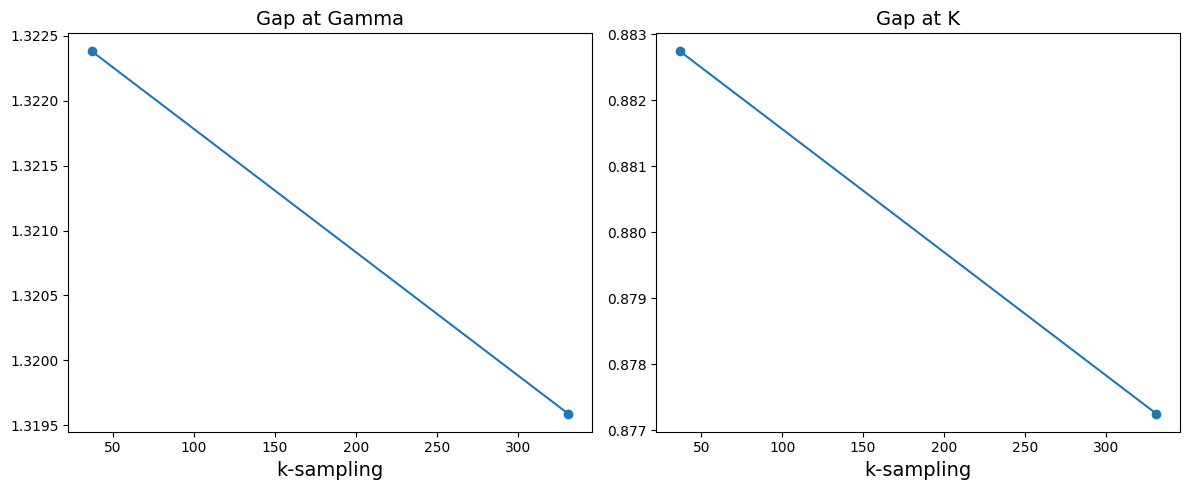

In [19]:
kpoints =  [37,331]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].plot(kpoints,gap_G)
axes[0].scatter(kpoints,gap_G)
axes[0].set_title('Gap at Gamma',size=14)
axes[0].set_xlabel('k-sampling',size=14)
axes[1].plot(kpoints, gap_K)
axes[1].scatter(kpoints,gap_K)
axes[1].set_xlabel('k-sampling',size=14)
axes[1].set_title('Gap at K',size=14)
fig.tight_layout()

## Quasi-particle band structure

In [20]:
# RunRules for leonardo
nodes = 4
ntasks_per_node = 4
cpus_per_task = 8
omp_num_threads = 8
gres_gpu=4
pe=8
module = '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu'

ntasks = nodes*ntasks_per_node

rr = C.RunRules(scheduler='slurm',partition='boost_usr_prod',
                account='IscrC_AGSL5',
                time='23:59:00',
                nodes=nodes,ntasks_per_node=ntasks_per_node,
                cpus_per_task=cpus_per_task,omp_num_threads=omp_num_threads,
                gres_gpu=gres_gpu,omp_places='cores',omp_proc_bind='close',pe=pe,
                map_by='socket',rank_by='core',pre_processing=module)
code = C.YamboCalculator(rr)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'scheduler': 'slurm',
 'nodes': 4,
 'ntasks_per_node': 4,
 'cpus_per_task': 8,
 'omp_num_threads': 8,
 'gpus_per_node': None,
 'gres_gpu': 4,
 'memory': None,
 'time': '23:59:00',
 'partition': 'boost_usr_prod',
 'account': 'IscrC_AGSL5',
 'qos': None,
 'omp_places': 'cores',
 'omp_proc_bind': 'close',
 'map_by': 'socket',
 'pe': 8,
 'rank_by': 'core',
 'pre_processing': '/leonardo/home/userexternal/mdaless1/module_script/yambo-5.3.0_gpu',
 'executable': 'yambo',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'activate_BeeOND': False,
 'verbose': True,
 'fatlog': False}

We use the convergence test performed above to computed the GW correction in the whole BZ. 
In this way we can compute the quasi-particle correction of the band structure.

In order to aviod a great (and not necessary) computational load compute the GW correction directly along the high symmetry path in an analogous way of what done in QuantumEspresso.

We work in the 60x60x1 kpoints grid.

In [23]:
kpoints = '60x60x1'
ksamplings = {'18x18x1': {'folder':'kpoints_18-nbnds_500','K_index':37,'G_index':1},
             '60x60x1': {'folder':'kpoints_60-nbnds_500','K_index':331,'G_index':1},
            }
run_dir = os.path.join('MB_analysis',ksamplings[kpoints]['folder'])

In [24]:
nsdb = os.path.join(run_dir,'SAVE/ns.db1')
dft_data = P.YamboDftParser(nsdb)

Parse file : MB_analysis/kpoints_60-nbnds_500/SAVE/ns.db1


In [25]:
kpoints_all = dft_data.get_kpoints(use_scalar_alat=True)

number of kpoints = 331


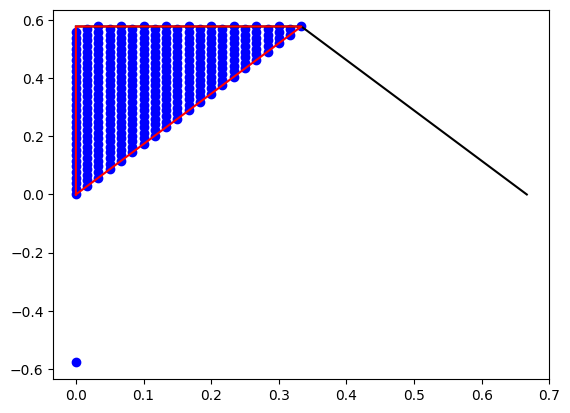

In [26]:
Gamma = np.array([0.,0.])
K = np.array([2./3.,0])
M = np.array([1./2.,1./(2*np.sqrt(3))])
Kp = np.array([1./3.,1./np.sqrt(3)])
Mp = np.array([0.,1./np.sqrt(3)])

BZ = [K, Kp, Mp]
print('number of kpoints = %s'%len(kpoints_all))
plt.plot(*np.column_stack(BZ),color='black')
IBZ = [Gamma,Kp, Mp,Gamma]
plt.plot(*np.column_stack(IBZ),color='red')
plt.scatter(kpoints_all[:,0],kpoints_all[:,1],c='blue')

We build a reduced array with a subset of kpoints close to the path on which we compute the GW band structure

The ind_path list contains the ordered list of all the kpoint along the selected path.
The values start from 1 for k the first point up to 331 for the last one

In [27]:
from mppi.Utilities import Utils

ind_path_GM, ind_path_MK, ind_path_KG = [],[],[]
tol = 0.005
for ind in range(len(kpoints_all)):
    Point = kpoints_all[ind][0],kpoints_all[ind][1]
    if U.Utils.is_point_near_line(Point,Gamma,Mp,tol): 
        ind_path_GM.append(ind+1)
    elif U.Utils.is_point_near_line(Point,Mp,Kp,tol): 
        ind_path_MK.append(ind+1)
    elif U.Utils.is_point_near_line(Point,Kp,Gamma,tol): 
        ind_path_KG.append(ind+1)     

ind_path = []
ind_path.extend(ind_path_GM)
ind_path.extend(ind_path_MK)
ind_path.extend(ind_path_KG[::-1]) # this list is reversed
#ind_path

number of sampled kpoints = 59


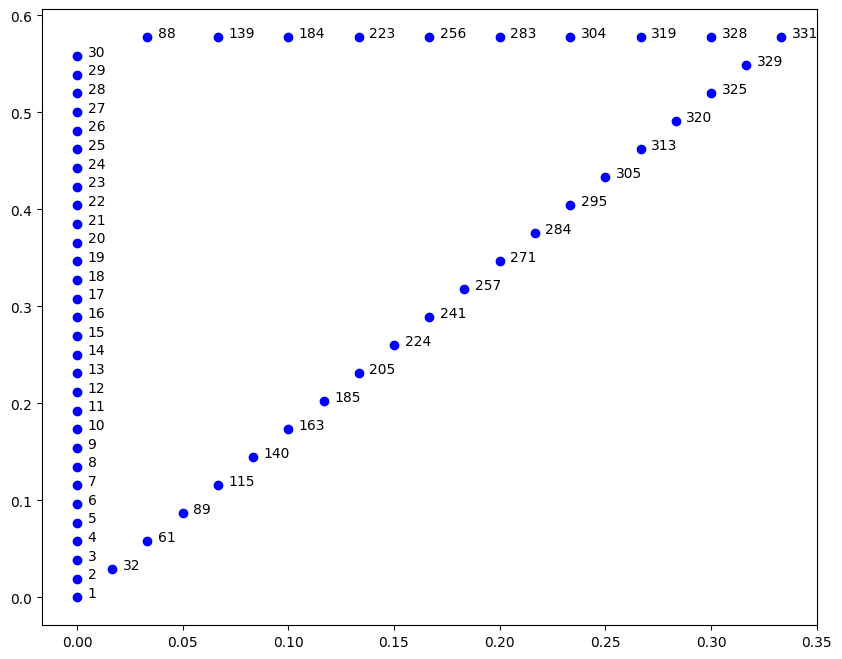

In [28]:
fig, ax1 = plt.subplots(figsize=(10,8))

print('number of sampled kpoints = %s'%len(ind_path))
for ind in ind_path:
    plt.scatter(kpoints_all[ind-1,0],kpoints_all[ind-1,1],c='blue')
    plt.text(kpoints_all[ind-1,0]+0.005,kpoints_all[ind-1,1],ind)

In [29]:
ntasks_c = 8
ntasks_v = int(ntasks/ntasks_c)
print(ntasks_c,ntasks_v)

start_band,stop_band = 25,32
RandGvec = 200
RandGvecW = 10
Randqpts = 5e6

EXXRLVcs_units = 'Ha'
EXXRLvcs = 40. # Ha
NGsBlkXp = 6.0 # Ha G size of the response function
NGsBlkXp_units = 'Ha'
BndsRnXp = [1,500]
GbndRnge  = [1,500] # Bands in the G function
LongDrXp=[1.,1.,0.] 

study = D.Dataset(num_tasks=16,verbose=True)
study.set_postprocessing_function(PP.yambo_parse_data)

inp = I.YamboInput(args='yambo -r -rw -k hartee -dyson n -gw0 p -V all',folder=run_dir)
inp.set_extendOut()
inp.set_array_variables(units=EXXRLVcs_units,EXXRLvcs=EXXRLvcs,VXCRLvcs=EXXRLvcs)
inp.set_array_variables(LongDrXp=LongDrXp)
inp.set_bandRange(start_band,stop_band)
inp.set_scalar_variables(CUTGeo='slab z')
inp.set_array_variables(RandQpts=Randqpts)
inp.set_array_variables(units='RL',RandGvec=RandGvec,RandGvecW=RandGvecW)
inp.set_scalar_variables(SE_ROLEs='q.qp.b',SE_CPU='1.1.16') # for 4 nodes on leonardo
inp.set_scalar_variables(X_and_IO_ROLEs='q.g.k.c.v',X_and_IO_CPU='1.1.1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_scalar_variables(DIP_ROLEs='k.c.v',DIP_CPU='1.%s.%s'%(ntasks_c,ntasks_v))
inp.set_array_variables(units=NGsBlkXp_units,NGsBlkXp=NGsBlkXp)
inp.set_array_variables(BndsRnXp=BndsRnXp,GbndRnge=GbndRnge)
inp.set_scalar_variables(GTermKind='BG')
for ind in ind_path:
    idd = 'pp-BZ-kpoint_%s'%(ind)
    inp.set_kRange(ind,ind)
    study.append_run(id=idd,input=inp,runner=code,run_dir=run_dir,
            jobname=[idd,'ndbs','ndb_em1d-ngsblkxp_6.0-bndsrnxp_500'],reformat=False)

8 2
Initialize a Dataset with 16 parallel tasks


In [31]:
#study.ids

In [33]:
#study.runs[0]

In [ ]:
results = study.run(selection=[ind for ind in range(30,60)]) #selection=[ind for ind in range(48,60)] 

Run the selection [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] with the parallel task_groups [[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], [46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]] 

Run the task [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45] 
run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F pp-BZ-kpoint_139.in -J "pp-BZ-kpoint_139,ndbs,ndb_em1d-ngsblkxp_6.0-bndsrnxp_500" -C pp-BZ-kpoint_139Skip the run of 
pp-BZ-kpoint_88
slurm submit: run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F pp-BZ-kpoint_184.in -J "pp-BZ-kpoint_184,ndbs,ndb_em1d-ngsblkxp_6.0-bndsrnxp_500" -C pp-BZ-kpoint_184 
cd MB_analysis/kpoints_60-nbnds_500 ; sbatch job_pp-BZ-kpoint_139.sh
slurm submit: computation pp-BZ-kpoint_139 is running...run command: mpirun -np 16 --map-by socket:PE=8 --rank-by core yambo -F pp-BZ-kpoint_223.in -J "pp-BZ-kpo

Once that the runs are performed we build the bands structure. To this scope we need to define
an instance of BandStructure class

In [36]:
ind_path.extend([1]) # ad Gamma at the end to close the path

In [37]:
kpoints_sampled = []
for ind in ind_path:
    kpoints_sampled.append(kpoints_all[ind-1])
kpoints_sampled = np.array(kpoints_sampled)
kpoints_sampled.shape

(60, 3)

In [38]:
data_dft = np.zeros((8,len(ind_path)))
data_gw = np.zeros((8,len(ind_path)))
print(data_dft.shape)

for ind in range(len(ind_path)):
    data = P.YamboOutputParser.from_file(os.path.join(run_dir,'pp-BZ-kpoint_%s/o-pp-BZ-kpoint_%s.qp'%(ind_path[ind],ind_path[ind])),verbose=False)
    data_dft[:,ind] = data['qp']['E0']
    data_gw[:,ind] = data['qp']['E']
valence_ind = 3
data_gw = data_gw-max(data_gw[valence_ind]) # shift the maximum of the gw valence band to zero

(8, 60)


In [39]:
dft_gap = min(data_dft[valence_ind+1])-max(data_dft[valence_ind])
gw_gap = min(data_gw[valence_ind+1])-max(data_gw[valence_ind])
print('DFT gap = ',dft_gap*1e3,' meV')
print('GW gap = ',gw_gap*1e3,' meV')

DFT gap =  447.404  meV
GW gap =  783.503  meV


In [42]:
kpoints_all[29] #  this is the closest point to Mp in the path, due to the lacking of the 30-point (real M) for symmetry reason

array([0.       , 0.5581053, 0.       ], dtype=float32)

In [43]:
Gamma = np.array([0.,0.,0.])
Kp = np.array([1./3.,1./np.sqrt(3),0.])
#Mp = np.array([0.,1./np.sqrt(3),0.])
Mp = np.array([0.,0.55810523,0.]) # use this approximated value beacuse computation at M is lacking for symmetry reasons

high_sym = {'G':Gamma,'K':Kp,'M':Mp} # in cartesian coordinates
high_sym

{'G': array([0., 0., 0.]),
 'K': array([0.33333333, 0.57735027, 0.        ]),
 'M': array([0.        , 0.55810523, 0.        ])}

In [44]:
bands_dft = U.BandStructure(kpoints_sampled,data_dft,high_sym_points=high_sym) 
bands_gw = U.BandStructure(kpoints_sampled,data_gw-max(data_gw[3]),high_sym_points=high_sym)

In [45]:
max(bands_dft.kpath)

1.5632619634270668

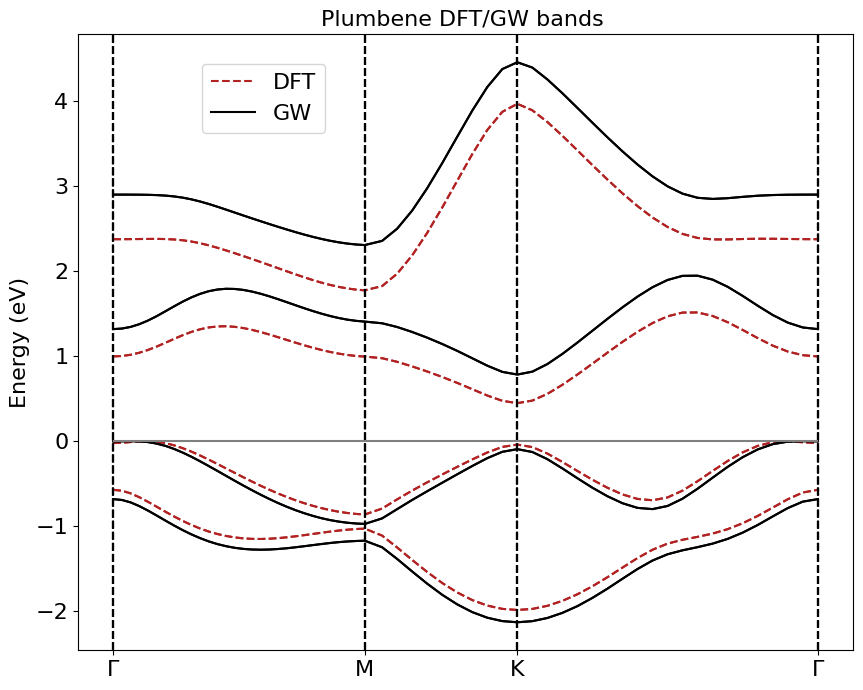

In [48]:
fig, ax1 = plt.subplots(figsize=(10,8))
bands_dft.plot(plt,axes=ax1,selection=[0],linestyle='--',label='DFT',c='firebrick')
bands_dft.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='--',c='firebrick')
bands_gw.plot(plt,axes=ax1,selection=[0],linestyle='-',label='GW',c='black')
bands_gw.plot(plt,axes=ax1,selection=[1,2,3,4,5,6,7],linestyle='-',c='black')
ax1.hlines(0.,0.,max(bands_dft.kpath),linestyles='-',color='gray')
#ax1.set_ylim(-0.5,0.5)
ax1.set_ylabel('Energy (eV)',size=16)
ax1.set_title('Plumbene DFT/GW bands ',size=16)
ax1.legend(loc=(0.16,0.84),fontsize=16,frameon=True)
ax1.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='Plot/Stanene-band_structure-kpoints_%s.eps'%kpoints,format='eps',bbox_inches = "tight")
plt.savefig(fname='Plot/Plumbene-band_structure-kpoints_%s.jpg'%kpoints,format='jpeg',bbox_inches = "tight")